In [1]:
with open('sample_name.txt','r') as f:
    name = f.read().split("\n")
    name_dict = {}
    for i in name:
        key, value = i.split(":")
        name_dict[key] = value
    number_of_samples = len(name_dict)

# 資料預處理

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True) 
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

Using TensorFlow backend.


In [3]:
training_set = train_datagen.flow_from_directory('trainset/', target_size = (64, 64), batch_size = 10,
                                                 class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('validationset/', target_size = (64, 64), batch_size = 10,
                                                        class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('testset/', target_size = (64, 64), batch_size = 10, 
                                            class_mode = 'categorical')

Found 373 images belonging to 2 classes.
Found 94 images belonging to 2 classes.
Found 117 images belonging to 2 classes.


# 建立模型

In [2]:
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dense

classifier = Sequential() 
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) 
classifier.add(MaxPooling2D(pool_size = (2, 2))) 
classifier.add(Conv2D(32, (3, 3), activation = 'relu')) 
classifier.add(MaxPooling2D(pool_size = (2, 2))) 
classifier.add(Flatten()) 
classifier.add(Dense(units = 128, activation = 'relu')) 
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = number_of_samples, activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

Using TensorFlow backend.


# 訓練模型

In [3]:
# try:
#     classifier.load_weights("SaveModel/face.h5")
#     print("載入模型成功!繼續訓練模型")
# except :    
#     print("載入模型失敗!開始訓練一個新模型")

載入模型成功!繼續訓練模型


In [6]:
history = classifier.fit_generator(training_set,
                                   nb_epoch=20,
                                   nb_val_samples=30,
                                   steps_per_epoch = 30,
                                   verbose = 1,
                                   validation_data = validation_set)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=30, verbose=1, validation_data=<keras.pre..., epochs=20, validation_steps=30)`
  


Epoch 1/20
30/30 [==============================] - 2s 77ms/step - loss: 0.6876 - acc: 0.6180 - val_loss: 0.6689 - val_acc: 0.7979
Epoch 2/20
30/30 [==============================] - 2s 58ms/step - loss: 0.5985 - acc: 0.7398 - val_loss: 0.4505 - val_acc: 0.7872
Epoch 3/20
30/30 [==============================] - 2s 58ms/step - loss: 0.4302 - acc: 0.8365 - val_loss: 0.3948 - val_acc: 0.7979
Epoch 4/20
30/30 [==============================] - 2s 58ms/step - loss: 0.4257 - acc: 0.8348 - val_loss: 0.3752 - val_acc: 0.8404
Epoch 5/20
30/30 [==============================] - 2s 58ms/step - loss: 0.4439 - acc: 0.8200 - val_loss: 0.3339 - val_acc: 0.8298
Epoch 6/20
30/30 [==============================] - 2s 58ms/step - loss: 0.3460 - acc: 0.8632 - val_loss: 0.2826 - val_acc: 0.8830
Epoch 7/20
30/30 [==============================] - 2s 58ms/step - loss: 0.3318 - acc: 0.8724 - val_loss: 0.2296 - val_acc: 0.8511
Epoch 8/20
30/30 [==============================] - 2s 57ms/step - loss: 0.2766 - a

# 驗證曲線

In [7]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(history.history[train_acc])
    plt.plot(history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

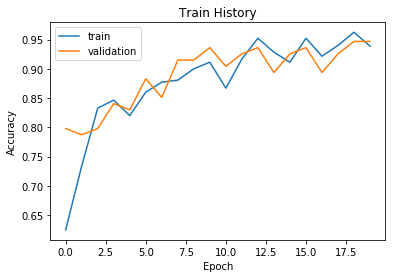

In [8]:
show_train_history('acc','val_acc')

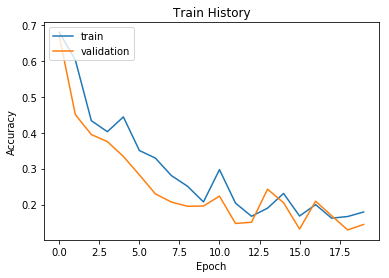

In [9]:
show_train_history('loss','val_loss')

# 模型預測

In [11]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'sample0_face\ANd9GcQbdIbsMTpT13ikSFXTMYvqA-YqzIuqZDeY6eWVMyhcJOdvb048YQ.jpg', target_size= (64,64))
test_image = image.img_to_array(test_image)
test_image.shape

(64, 64, 3)

In [12]:
test_image = np.expand_dims(test_image, axis = 0)
type(test_image)
test_image.shape

(1, 64, 64, 3)

In [13]:
classifier.predict_classes(test_image)

array([0], dtype=int64)

In [14]:
name_dict['sample'+str(classifier.predict_classes(test_image)[0])] 

'Harlem Yu'

# 評估模型

In [17]:
import os

testset_path = []   #testset_path為所有testset圖片路徑的list
for i in os.listdir('testset'):
    for j in os.listdir('testset/'+i):
        testset_path.append('testset/'+i+'/'+j)   

In [18]:
x_test_image = []
for path in testset_path:
    x_test_image.append(image.img_to_array(image.load_img(path, target_size= (64,64))))
x_test_image = np.array(x_test_image)/225

In [19]:
from keras.utils import np_utils
y_test_label = test_set.classes
y_Test_OneHot = np_utils.to_categorical(y_test_label)

In [20]:
test = []
for x, y, z in zip(x_test_image, y_test_label, y_Test_OneHot):
    test.append([x, y, z])

In [32]:
np.random.shuffle(test)

In [34]:
x_test_image = []
y_test_label = []
y_Test_OneHot = []
for i in test:
    x_test_image.append(i[0])
    y_test_label.append(i[1])
    y_Test_OneHot.append(i[2])
x_test_image = np.array(x_test_image)
y_test_label = np.array(y_test_label)
y_Test_OneHot = np.array(y_Test_OneHot)

# kkkkkkkkkkkkkkkkkkkkkkkk

In [136]:
x_test_image = []
for path in testset_path:
    x_test_image.append(image.img_to_array(image.load_img(path, target_size= (64,64))))
x_test_image = np.array(x_test_image)/225

In [137]:
from keras.utils import np_utils
y_test_label = test_set.classes
y_Test_OneHot = np_utils.to_categorical(y_test_label)

In [138]:
test = []
for x, y in zip(x_test_image, y_test_label):
    test.append([x, y])

In [139]:
np.random.shuffle(test)

In [104]:
test = np.array(test)

In [113]:
from keras.utils import np_utils
x_test_image = test[:,0]
y_test_label = test[:,1]
y_Test_OneHot = np_utils.to_categorical(y_test_label)

# kkkkkkkkkkkkkkkkkkkkkkkkkkk

In [21]:
prediction = classifier.predict_classes(x_test_image)               #預測

In [22]:
scores = classifier.evaluate(x_test_image, y_Test_OneHot, verbose=0)  #評估
scores[1]

0.94871795024627292

In [23]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= "label=" +str(labels[idx])
        if len(prediction)>0:
            title+=",predict="+str(prediction[idx]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

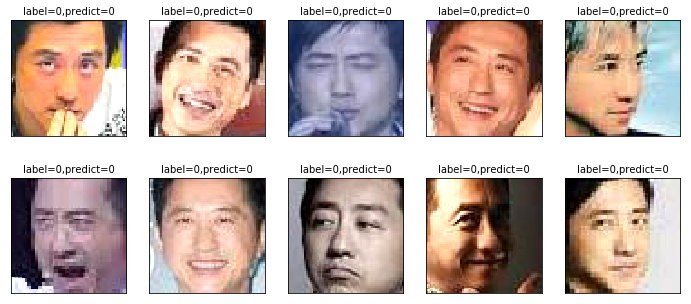

In [24]:
plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=10)

# 混淆矩陣

In [25]:
import pandas as pd
pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict'])

predict,0,1
label,,
0,46,0
1,6,65


# 儲存模型

In [26]:
import os

if not os.path.exists('SaveModel'):
    os.mkdir('SaveModel')
classifier.save('SaveModel/face.hd5')
print("Saved model to disk")

Saved model to disk
